In [38]:
# %cd code
# insert your desired path to work on
import os
from os.path import join
project_path = os.path.dirname(os.getcwd())
# os.chdir(join('..','data'))
os.getcwd()

'C:\\Users\\amanp\\Desktop\\MINOR\\projj\\code'

In [39]:
import sys
sys.path.append(join(project_path, 'code'))

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Plots settings.**

In [41]:
import matplotlib
font = {'family':'Arial', 'size':'15', 'weight':'normal'}

matplotlib.rc('font', **font)

**Set folder structure.**

In [42]:
config = {
    'main_brazil': 'Brazil',
    'main_peru': 'Peru',
    'baseline': join(project_path, "baseline_models"),
    'output': join(project_path, "code", "saved_models"),
    'metrics': join(project_path, "code", "metrics")
}
project_path

# List comprehension for the folder structure code
[os.makedirs(val, exist_ok=True) for key, val in config.items()]

[None, None, None, None, None]

# **AI4Dengue forecasting**
![](https://drive.google.com/uc?export=view&id=1J5Bt5Cks-e2IV-dEJLHJkuwXFJNFAZgr)

In [43]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from glob import glob
from config import DEP_NAMES, GROUPED_VARS, DATA_REDUCER_SETTINGS, DATA_PROCESSING_SETTINGS


In [44]:
dir(utils)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean',
 'cx',
 'geopandas',
 'pd',
 'plist',
 'plotShape']

# Data

## Load the dataframe
**This dataframe comprises all the variables (climatic, epidemiological etc.) acquired for each Department during a defined number of years.**

In [45]:
dataframe = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
dataframe.head()
dataframe.iloc[1000]

Date                2004-02-01
Year                      2004
Month                        2
CD_UF                       12
area_km2            164173.431
                       ...    
rdpc_def_vulner         119.68
t_analf_18m              17.79
t_formal_18m             46.45
t_fundc_ocup18m           55.2
t_medioc_ocup18m         39.61
Name: 1000, Length: 62, dtype: object

**Load CNN results as columns to dataframe.**

In [46]:
cnn = pd.read_csv(join('saved_models', "cnn_dataframe.csv")).drop('Unnamed: 0', axis=1)
cnn['CD_UF'] = cnn['CD_UF'].astype(np.int64)

assert dataframe.shape[0] == cnn.shape[0]
assert all(dataframe['CD_UF'].unique() == cnn['CD_UF'].unique())
cnn

,CD_UF,CNN_all,CNN_0-19
0,11,1.000000,1.000000
1,11,1.000000,1.000000
2,11,1.000000,1.000000
3,11,1.000000,1.000000
4,11,32.159859,17.186546
...,...,...,...
6151,53,29.022461,16.795465
6152,53,20.277210,5.658783
6153,53,7.219064,16.862005
6154,53,17.866333,28.619926


In [47]:
dataframe.sort_values(['CD_UF', 'Date'], inplace=True, ignore_index=True)
dataframe

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,pea10a14,pea15a17,pea18m,t_eletrica,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2019-08-01,2019,8,53,5760.784,0.362744,282.150351,42.202163,304.210083,287.271135,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6152,2019-09-01,2019,9,53,5760.784,0.317748,281.820936,34.023500,307.566780,290.719267,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6153,2019-10-01,2019,10,53,5760.784,0.271795,286.196146,45.486547,307.716003,291.720099,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6154,2019-11-01,2019,11,53,5760.784,0.235493,290.445969,64.916154,306.706715,291.496597,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00


In [48]:
dataframe = pd.concat([dataframe, cnn[['CNN_all', 'CNN_0-19']]], axis=1)
dataframe

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,pea18m,t_eletrica,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m,CNN_all,CNN_0-19
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,32.159859,17.186546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2019-08-01,2019,8,53,5760.784,0.362744,282.150351,42.202163,304.210083,287.271135,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,29.022461,16.795465
6152,2019-09-01,2019,9,53,5760.784,0.317748,281.820936,34.023500,307.566780,290.719267,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,20.277210,5.658783
6153,2019-10-01,2019,10,53,5760.784,0.271795,286.196146,45.486547,307.716003,291.720099,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,7.219064,16.862005
6154,2019-11-01,2019,11,53,5760.784,0.235493,290.445969,64.916154,306.706715,291.496597,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,17.866333,28.619926


**'Clean' the dataset (e.g. remove NaN values)**

In [49]:
dataframe = utils.clean(dataframe)
dataframe.head()

Cleaning dataframe...


,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m,CNN_all,CNN_0-19,rate_total,rate_019
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,42.754490,29.124122
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,17.601025,11.718582
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,11.072645,6.376287
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,5.120298,3.791306
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,27.15,144.93,9.42,51.72,53.83,36.93,32.159859,17.186546,6.976406,4.652966


In [50]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       6156 non-null   object 
 1   Year                       6156 non-null   int64  
 2   Month                      6156 non-null   int64  
 3   CD_UF                      6156 non-null   int64  
 4   area_km2                   6156 non-null   float64
 5   NDVI_d                     6156 non-null   float64
 6   dewpoint_temperature_2m_d  6156 non-null   float64
 7   humidity_d                 6156 non-null   float64
 8   max_temperature_2m_d       6156 non-null   float64
 9   min_temperature_2m_d       6156 non-null   float64
 10  surface_pressure_d         6156 non-null   float64
 11  temperature_2m_d           6156 non-null   float64
 12  total_precipitation_d      6156 non-null   float64
 13  u_component_of_wind_10m_d  6156 non-null   float

## Apply Data Reduction
**Data reduction is applied to three macro groups in order to reduce the number of variables on which the AI framework will be trained. The variables belonging to each group are set with the *PCAgroups* dictionary. The groups are:**
1. ***CLIMATIC VARIABLES***,
2. ***GEO VARIABLES***,
3. ***SOCIO VARIABLES***

In [51]:
print('\033[1m PCA Excluded Variables \033[0m')
utils.plist(GROUPED_VARS['EXCLUDED'])

print('\033[1m Climatic variables \033[0m')
utils.plist(GROUPED_VARS['CLIMATIC VARIABLES'])

print('\033[1m Geo variables \033[0m')
utils.plist(GROUPED_VARS['GEO VARIABLES'])

print('\033[1m Socio variables \033[0m')
utils.plist(GROUPED_VARS['SOCIO VARIABLES'])

print('\033[1m Additional variables \033[0m')
utils.plist(GROUPED_VARS['AUXILIAR'])

print('\033[1m Dengue variables \033[0m')
utils.plist(GROUPED_VARS['DENGUE'])

 PCA Excluded Variables 
----- 1 t_fundc_ocup18m
----- 2 t_medioc_ocup18m
----- 3 PopTotal_Urban_UF
----- 4 PopTotal_Rural_UF
----- 5 total_precipitation_d
----- 6 surface_pressure_d
----- 7 area_km2
----- 8 humidity_d
----- 9 temperature_2m_d
----- 10 min_temperature_2m_d
----- 11 CNN_all
----- 12 CNN_0-19
 Climatic variables 
----- 1 dewpoint_temperature_2m_d
----- 2 max_temperature_2m_d
----- 3 u_component_of_wind_10m_d
----- 4 v_component_of_wind_10m_d
 Geo variables 
----- 1 NDVI_d
----- 2 max_elevation_d
----- 3 mean_elevation_d
----- 4 min_elevation_d
----- 5 stdDev_elevation_d
----- 6 variance_elevation_d
----- 7 Forest_Cover_Percent
----- 8 Urban_Cover_Percent
 Socio variables 
----- 1 Urban_Cover_Percent
----- 2 ivs
----- 3 ivs_infraestrutura_urbana
----- 4 ivs_capital_humano
----- 5 ivs_renda_e_trabalho
----- 6 t_sem_agua_esgoto
----- 7 t_sem_lixo
----- 8 t_vulner_mais1h
----- 9 t_analf_15m
----- 10 t_cdom_fundin
----- 11 t_p15a24_nada
----- 12 t_vulner
----- 13 t_desocup18m

**We selected two types of data reduction methods: PCA (Principal Component Analysis) and PLS (Principal Least Square). The second one is the default solution because it reduces the input data by considering also a second variable that in our case is the Dengue Incidence Rates.**

In [52]:
from data_reduction import pca_reducer, pls_reducer

In [53]:
scaler = MinMaxScaler()
print(dataframe.columns)

Index(['Date', 'Year', 'Month', 'CD_UF', 'area_km2', 'NDVI_d',
       'dewpoint_temperature_2m_d', 'humidity_d', 'max_temperature_2m_d',
       'min_temperature_2m_d', 'surface_pressure_d', 'temperature_2m_d',
       'total_precipitation_d', 'u_component_of_wind_10m_d',
       'v_component_of_wind_10m_d', 'max_elevation_d', 'mean_elevation_d',
       'min_elevation_d', 'stdDev_elevation_d', 'variance_elevation_d',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'cases0_19', 'cases20_99',
       'Forest_Cover_Percent', 'Urban_Cover_Percent', 'ivs',
       'ivs_infraestrutura_urbana', 'ivs_capital_humano',
       'ivs_renda_e_trabalho', 't_sem_agua_esgoto', 't_sem_lixo',
       't_vulner_mais1h', 't_analf_15m', 't_cdom_fundin', 't_p15a24_nada',
       't_vulner', 't_desocup18m', 't_p18m_fundin_informal', 'idhm',
       'idhm_long', 'idhm_educ', 'idhm_renda', 'idhm_educ_sub_esc',
       't_pop18m_fundc', 'idhm_educ_sub_freq', 'renda_per_capita', 'pea10a14',
       'pea15a17', 'pea18m', '

**Extract climatic, geophysical and socio-economic variables from the dataframe**

In [54]:
X_climatic = scaler.fit_transform(dataframe[GROUPED_VARS['CLIMATIC VARIABLES']].values)
X_geo = scaler.fit_transform(dataframe[GROUPED_VARS['GEO VARIABLES']].values)
X_socio = scaler.fit_transform(dataframe[GROUPED_VARS['SOCIO VARIABLES']].values)
y_dengue = dataframe[GROUPED_VARS['DENGUE']].values  # Keep y_dengue unscaled for no


In [55]:
print(dataframe.columns)

Index(['Date', 'Year', 'Month', 'CD_UF', 'area_km2', 'NDVI_d',
       'dewpoint_temperature_2m_d', 'humidity_d', 'max_temperature_2m_d',
       'min_temperature_2m_d', 'surface_pressure_d', 'temperature_2m_d',
       'total_precipitation_d', 'u_component_of_wind_10m_d',
       'v_component_of_wind_10m_d', 'max_elevation_d', 'mean_elevation_d',
       'min_elevation_d', 'stdDev_elevation_d', 'variance_elevation_d',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'cases0_19', 'cases20_99',
       'Forest_Cover_Percent', 'Urban_Cover_Percent', 'ivs',
       'ivs_infraestrutura_urbana', 'ivs_capital_humano',
       'ivs_renda_e_trabalho', 't_sem_agua_esgoto', 't_sem_lixo',
       't_vulner_mais1h', 't_analf_15m', 't_cdom_fundin', 't_p15a24_nada',
       't_vulner', 't_desocup18m', 't_p18m_fundin_informal', 'idhm',
       'idhm_long', 'idhm_educ', 'idhm_renda', 'idhm_educ_sub_esc',
       't_pop18m_fundc', 'idhm_educ_sub_freq', 'renda_per_capita', 'pea10a14',
       'pea15a17', 'pea18m', '

**Apply data reduction technique**

In [56]:
if DATA_REDUCER_SETTINGS['TYPE'] == 'PLS':
    climatic_vars_reduced = pls_reducer(
        X_climatic, y_dengue, 
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES']
    )
    geo_vars_reduced = pls_reducer(
        X_geo, y_dengue, 
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES']
    )
    socio_vars_reduced = pls_reducer(
        X_socio, y_dengue, 
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES']
    )
    print(socio_vars_reduced.shape)
elif DATA_REDUCER_SETTINGS['TYPE'] == 'PCA':
    climatic_vars_reduced = pca_reducer(
        X_climatic, 
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES']
    )
    geo_vars_reduced = pca_reducer(
        X_geo, 
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES']
    )
    socio_vars_reduced = pca_reducer(
        X_socio, 
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES']
    )
else:
    print('No data reduction.')
    climatic_vars_reduced, geo_vars_reduced, socio_vars_reduced = X_climatic, X_geo, X_socio

(6156, 10)


## Order reduced data in a new dataframe


**Normalize remaining variables**

In [57]:
print(dataframe.columns)

Index(['Date', 'Year', 'Month', 'CD_UF', 'area_km2', 'NDVI_d',
       'dewpoint_temperature_2m_d', 'humidity_d', 'max_temperature_2m_d',
       'min_temperature_2m_d', 'surface_pressure_d', 'temperature_2m_d',
       'total_precipitation_d', 'u_component_of_wind_10m_d',
       'v_component_of_wind_10m_d', 'max_elevation_d', 'mean_elevation_d',
       'min_elevation_d', 'stdDev_elevation_d', 'variance_elevation_d',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'cases0_19', 'cases20_99',
       'Forest_Cover_Percent', 'Urban_Cover_Percent', 'ivs',
       'ivs_infraestrutura_urbana', 'ivs_capital_humano',
       'ivs_renda_e_trabalho', 't_sem_agua_esgoto', 't_sem_lixo',
       't_vulner_mais1h', 't_analf_15m', 't_cdom_fundin', 't_p15a24_nada',
       't_vulner', 't_desocup18m', 't_p18m_fundin_informal', 'idhm',
       'idhm_long', 'idhm_educ', 'idhm_renda', 'idhm_educ_sub_esc',
       't_pop18m_fundc', 'idhm_educ_sub_freq', 'renda_per_capita', 'pea10a14',
       'pea15a17', 'pea18m', '

In [58]:
## Normalizing remaining variables
x_excluded = scaler.fit_transform(dataframe[GROUPED_VARS['EXCLUDED']].values)
X_auxiliar = scaler.fit_transform(dataframe[GROUPED_VARS['AUXILIAR']].values)

**Create a new database with the reduced, the auxiliar and Dengue variables**

In [59]:
rand_effects = np.array([
    dataframe.CD_UF.values * dataframe.Month.values,
    dataframe.CD_UF.values * dataframe.Year.values,
    dataframe.CD_UF.values * dataframe.Month.values * dataframe.Year.values
]).T
rand_effects_scaled = scaler.fit_transform(rand_effects)

In [60]:
# Creating a new database with the reduced, the auxiliary, and Dengue variables
independent = {'Year': dataframe.Year.values, 'dep_id': dataframe.CD_UF.values}
for i, var in enumerate(GROUPED_VARS['EXCLUDED']):
    independent[var] = x_excluded[:, i]

In [61]:
auxiliar = {
    'Month': X_auxiliar[:, 0],
    'cases20_99': X_auxiliar[:, 1], 
    'cases0_19': X_auxiliar[:, 2],
    'RandEffects1': rand_effects_scaled[:, 0],
    'RandEffects2': rand_effects_scaled[:, 1],
    'RandEffects3': rand_effects_scaled[:, 2]
}

climatic = {f'PCA{i}-Climatic': climatic_vars_reduced[:, i] for i in range(climatic_vars_reduced.shape[1])}
geo = {f'PCA{i}-Geo': geo_vars_reduced[:, i] for i in range(geo_vars_reduced.shape[1])}
socio = {f'PCA{i}-Socio': socio_vars_reduced[:, i] for i in range(socio_vars_reduced.shape[1])}

dengue = {'rate_total': y_dengue[:,0], 'rate_019': y_dengue[:,1]}

columns = {**independent, **auxiliar, **climatic, **geo, **socio, **dengue}

reduced_dataframe = pd.DataFrame(columns)
reduced_dataframe = reduced_dataframe[reduced_dataframe['Year'] >= 2004]

# Save the data
reduced_dataframe.to_csv('reduced_2004_2019.csv', index=False)
print("Reduced DataFrame shape:", reduced_dataframe.shape)

Reduced DataFrame shape: (5184, 42)


In [62]:
print(reduced_dataframe.columns)

Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'PCA6-Socio', 'PCA7-Socio', 'PCA8-Socio', 'PCA9-Socio',
       'rate_total', 'rate_019'],
      dtype='object')


## Create training and validation data
**First of all, the dataframe is divided in two sub-dataframes (training and validation) by using the variable *Year***

In [63]:
dataset_path = os.path.join("..", "google trends", "merged_dataset.csv")
reduced_dataframe = pd.read_csv(dataset_path)
# Print shape and column names
print("Dataset Shape:", reduced_dataframe.shape)
print("Columns:", reduced_dataframe.columns)

Dataset Shape: (5184, 41)
Columns: Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'mosquito_interest', 'sintomas_dengue_interest',
       'dengue_interest', 'DengRate_all', 'DengRate_019'],
      dtype='object')


In [64]:
# Split data
training_dataframe = reduced_dataframe[reduced_dataframe.Year < 2017].copy()
validation_dataframe = reduced_dataframe[reduced_dataframe.Year >= 2017].copy()
print(f"Training Size: {len(training_dataframe)}, Validation Size: {len(validation_dataframe)}")
# Check for missing values
print("Missing values in training set:", training_dataframe.isnull().sum().sum())
print("Missing values in validation set:", validation_dataframe.isnull().sum().sum())

Training Size: 4212, Validation Size: 972
Missing values in training set: 0
Missing values in validation set: 0


In [65]:
# Handle missing values (if any)
if training_dataframe.isnull().sum().sum() > 0 or validation_dataframe.isnull().sum().sum() > 0:
    # Here you would implement some strategy for dealing with missing data
    # e.g., `training_dataframe = training_dataframe.fillna(method='ffill')`
    pass

In [66]:
training_dataframe["DengRate_all_log"] = np.log1p(training_dataframe["DengRate_all"])
validation_dataframe["DengRate_all_log"] = np.log1p(validation_dataframe["DengRate_all"])

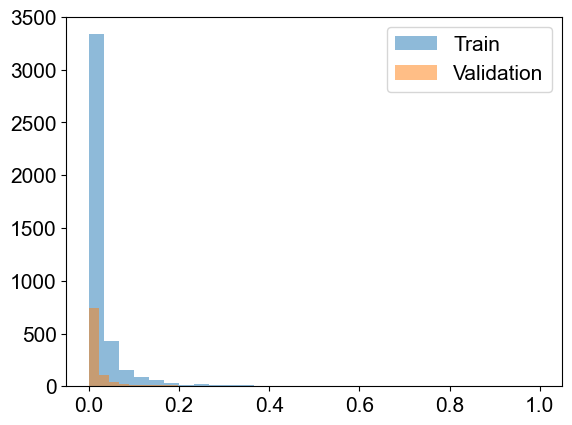

In [67]:
import matplotlib.pyplot as plt

# Replace 'rate_total' with 'DengRate_all' (or 'DengRate_019' if needed)
plt.hist(training_dataframe["DengRate_all"], bins=30, alpha=0.5, label="Train")
plt.hist(validation_dataframe["DengRate_all"], bins=30, alpha=0.5, label="Validation")
plt.legend()
plt.show()

**Then the dataset handler is initialized. This object will handle all the operations needed to create, reshape and augment the training and validation dataset to fit the requirements of each Deep Learning or Machine Learning model.**

In [68]:
from datasetHandler import datasetHandler

In [69]:
# Initialize dataset handler with filtered data
dataset_handler = datasetHandler(training_dataframe, validation_dataframe)

In [70]:
# Fetch training/validation data & indices
x_train, y_train, x_val, y_val, train_indices, val_indices = dataset_handler.get_data(
    DATA_PROCESSING_SETTINGS["T LEARNING"], DATA_PROCESSING_SETTINGS["T PREDICTION"]
)

INFO:root:Preparing data with window size 12 and prediction horizon 1


X Training shape (3888, 12, 42)
Y Training shape (3888, 2)
Processing departments 26 of 27		
X Validation shape (648, 12, 42)
Y Validation shape (648, 2)
Processing departments 26 of 27		

In [71]:
# Print shapes
print("\nX Training shape:", x_train.shape)
print("Y Training shape:", y_train.shape)
print("X Validation shape:", x_val.shape)
print("Y Validation shape:", y_val.shape)


X Training shape: (3888, 12, 42)
Y Training shape: (3888, 2)
X Validation shape: (648, 12, 42)
Y Validation shape: (648, 2)


**Apply data augmention**

In [72]:
# Applying data augmentation with dynamic noise scaling
x_train_a, y_train_a, x_val_a, y_val_a = dataset_handler.augment(
    x_train, y_train, x_val, y_val, DATA_PROCESSING_SETTINGS["AUGMENTATION"]
)

In [73]:
# Print augmented shapes
print("X Training Augmented shape:", x_train_a.shape)
print("Y Training Augmented shape:", y_train_a.shape)
print("X Validation Augmented shape:", x_val_a.shape)
print("Y Validation Augmented shape:", y_val_a.shape)

X Training Augmented shape: (11664, 12, 42)
Y Training Augmented shape: (11664, 2)
X Validation Augmented shape: (1944, 12, 42)
Y Validation Augmented shape: (1944, 2)


In [75]:
# # Example before training or prediction
# training_dataframe = remove_outliers(training_dataframe, 'DengRate_all')
# validation_dataframe = remove_outliers(validation_dataframe, 'DengRate_all')

# TCN

In [76]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, BatchNormalization, Dropout, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import root_mean_squared_error
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
from glob import glob
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from config import TCN_SETTINGS, DEP_NAMES
from datasetHandler import datasetHandler
import shap
from tensorflow.keras import layers, models, regularizers, Input
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

C:\Users\amanp\.conda\envs\minor\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
# Utility functions for metrics calculation
def calculate_nrmse(true_values, predicted_values):
    return mean_absolute_percentage_error(true_values, predicted_values)

def calculate_mae(true_values, predicted_values):
    return mean_absolute_error(true_values, predicted_values)

def calculate_mse(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values)

def calculate_rmse(mse):
    return np.sqrt(mse)

def calculate_mape(true_values, predicted_values):
    return mean_absolute_percentage_error(true_values, predicted_values)

def calculate_r2(true_values, predicted_values):
    return r2_score(true_values, predicted_values)

def discretize_to_binary(values, threshold=0.5):
    return np.where(values > threshold, 1, 0)

def plot_confusion_matrix(true_values, predicted_values, department_name, metric_type="All"):
    cm = confusion_matrix(true_values, predicted_values)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix: {department_name} - {metric_type}')
    plt.show()

# Define model architecture
def build_tcn_model_v2(input_shape, output_units, num_filters, dropout_rate, l2_reg, num_residual_blocks):
    def residual_block(x, filters, dilation_rate):
        shortcut = x
        x = layers.Conv1D(filters, 3, padding='causal', activation='relu',
                         dilation_rate=dilation_rate, kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.add([x, shortcut])
        return layers.ReLU()(x)

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(num_filters, 3, padding='causal', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(TCN_SETTINGS['INITIAL_DROPOUT_RATE'])(x)
    
    for dilation in TCN_SETTINGS['DILATION_RATES'][:num_residual_blocks]:
        x = residual_block(x, num_filters, dilation)
        
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(output_units, activation='linear')(x)
    return models.Model(inputs, outputs)

class ImprovedTCNNet:
    def __init__(self, shape, output_units=2):
        self.shape = shape
        self.epochs = TCN_SETTINGS['EPOCHS']
        self.batch_size = TCN_SETTINGS['BATCH_SIZE']
        self.lr = TCN_SETTINGS['LEARNING_RATE']
        self.early_stopping_rounds = TCN_SETTINGS['EARLY_STOPPING_PATIENCE']
        self.dropout_rate = TCN_SETTINGS['DROPOUT_RATE']
        self.l2_regularization = 1e-3  # Default, adjust if needed
        self.num_filters = TCN_SETTINGS['NUM_FILTERS']
        self.num_residual_blocks = len(TCN_SETTINGS['DILATION_RATES'])
        
        # Build the uncompiled model
        self.model = build_tcn_model_v2(
            self.shape, output_units, self.num_filters,
            self.dropout_rate, self.l2_regularization, self.num_residual_blocks
        )
        
        # Compile the model
        self.model.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss=TCN_SETTINGS['LOSS'],
            metrics=TCN_SETTINGS['EVALUATION_METRIC']
        )
    
    def load(self, model_path):
        self.model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")

    def train(self, training, validation, output_path):
        es = EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_rounds,
            restore_best_weights=True
        )
        
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            x=training[0],
            y=training[1],
            validation_data=(validation[0], validation[1]),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es, lr_scheduler],
            shuffle=True
        )

        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Improved TCN Model Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        model_filename = f"TCN-new-search-{today}.keras"
        os.makedirs(output_path, exist_ok=True)
        save_path = os.path.join(output_path, model_filename)
        self.model.save(save_path)
        print(f"Model saved to {save_path}")

        return history


In [ ]:


# # Utility functions for metrics calculation
# def calculate_nrmse(true_values, predicted_values):
#     rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
#     return rmse / (true_values.max() - true_values.min()) if true_values.max() != true_values.min() else 0

# def calculate_mae(true_values, predicted_values):
#     return mean_absolute_error(true_values, predicted_values)

# def calculate_mse(true_values, predicted_values):
#     return mean_squared_error(true_values, predicted_values)

# def calculate_rmse(mse):
#     return np.sqrt(mse)

# def calculate_mape(true_values, predicted_values):
#     mask = true_values > 0
#     return np.mean(np.abs((true_values[mask] - predicted_values[mask]) / true_values[mask])) * 100 if mask.any() else 0

# def calculate_r2(true_values, predicted_values):
#     return r2_score(true_values, predicted_values)

# # TCN Model Definition
# def build_tcn_model_v2(input_shape, output_units, num_filters, dropout_rate, l2_reg, num_residual_blocks):
#     def residual_block(x, filters, dilation_rate):
#         shortcut = x
#         x = layers.Conv1D(filters, 3, padding='causal', activation='relu',
#                           dilation_rate=dilation_rate, kernel_regularizer=regularizers.l2(l2_reg))(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(dropout_rate)(x)
#         x = layers.add([x, shortcut])
#         return layers.ReLU()(x)

#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv1D(num_filters, 3, padding='causal', activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(TCN_SETTINGS['INITIAL_DROPOUT_RATE'])(x)
    
#     for dilation in TCN_SETTINGS['DILATION_RATES'][:num_residual_blocks]:
#         x = residual_block(x, num_filters, dilation)
        
#     x = layers.GlobalAveragePooling1D()(x)
#     outputs = layers.Dense(output_units, activation='linear')(x)
#     return models.Model(inputs, outputs)

# class ImprovedTCNNet:
#     def __init__(self, shape, output_units=2):
#         self.shape = shape
#         self.epochs = TCN_SETTINGS['EPOCHS']
#         self.batch_size = TCN_SETTINGS['BATCH_SIZE']
#         self.lr = TCN_SETTINGS['LEARNING_RATE']
#         self.early_stopping_rounds = TCN_SETTINGS['EARLY_STOPPING_PATIENCE']
#         self.dropout_rate = TCN_SETTINGS['DROPOUT_RATE']
#         self.l2_regularization = TCN_SETTINGS['L2_REGULARIZATION']
#         self.num_filters = TCN_SETTINGS['NUM_FILTERS']
#         self.num_residual_blocks = len(TCN_SETTINGS['DILATION_RATES'])
        
#         self.model = build_tcn_model_v2(
#             self.shape, output_units, self.num_filters,
#             self.dropout_rate, self.l2_regularization, self.num_residual_blocks
#         )
        
#         self.model.compile(
#             optimizer=Adam(learning_rate=self.lr),
#             loss=TCN_SETTINGS['LOSS'],
#             metrics=TCN_SETTINGS['EVALUATION_METRIC']
#         )
    
#     def load(self, model_path):
#         self.model = tf.keras.models.load_model(model_path)
#         print(f"Model loaded successfully from {model_path}")

#     def train(self, training, validation, output_path):
#         es = EarlyStopping(
#             monitor='val_loss',
#             min_delta=0.001,
#             patience=self.early_stopping_rounds,
#             verbose=1,
#             restore_best_weights=True
#         )
        
#         lr_scheduler = ReduceLROnPlateau(
#             monitor='val_loss',
#             factor=0.5,
#             patience=5,
#             min_lr=1e-6,
#             verbose=1
#         )
        
#         print(f"Training Data Shapes: Input {training[0].shape}, Output {training[1].shape}")
#         print(f"Validation Data Shapes: Input {validation[0].shape}, Output {validation[1].shape}")

#         history = self.model.fit(
#             x=training[0],
#             y=training[1],
#             validation_data=(validation[0], validation[1]),
#             epochs=self.epochs,
#             batch_size=self.batch_size,
#             callbacks=[es, lr_scheduler],
#             shuffle=True,
#             verbose=1
#         )

#         plt.figure(figsize=(8, 6))
#         plt.plot(history.history['loss'], label='Train Loss')
#         plt.plot(history.history['val_loss'], label='Validation Loss')
#         plt.legend()
#         plt.title('Improved TCN Model Loss Curve')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.show()

#         today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
#         model_filename = f"TCN-new-search-{today}.keras"
#         save_path = os.path.join(output_path, model_filename)
#         os.makedirs(output_path, exist_ok=True)
#         self.model.save(save_path)
#         print(f"Model saved to {save_path}")
#         return history

In [94]:
# Training and Evaluation Setup
output_path = os.path.join(config['output'], "Brazil")
os.makedirs(output_path, exist_ok=True)

TRAINING = False

# Define metric columns
metric_columns = [
    'Department',
    'MAE (DengRate_all) Val', 'RMSE (DengRate_all) Val', 'MAPE (DengRate_all) Val', 'R2 (DengRate_all) Val', 'MSE (DengRate_all) Val',
    'MAE (DengRate_019) Val', 'RMSE (DengRate_019) Val', 'MAPE (DengRate_019) Val', 'R2 (DengRate_019) Val', 'MSE (DengRate_019) Val',
    'MAE (DengRate_all) Train', 'RMSE (DengRate_all) Train', 'MAPE (DengRate_all) Train', 'R2 (DengRate_all) Train', 'MSE (DengRate_all) Train',
    'MAE (DengRate_019) Train', 'RMSE (DengRate_019) Train', 'MAPE (DengRate_019) Train', 'R2 (DengRate_019) Train', 'MSE (DengRate_019) Train'
]

# Initialize TCN model
tcn = ImprovedTCNNet(trainingT[0].shape[1:])  # Use shape from training data

if TRAINING:
    print("Training the model...")
    trainingT, validationT = dataset_handler.prepare_data_TCN(x_train_a, y_train_a, x_val_a, y_val_a)
    history = tcn.train(trainingT, validationT, output_path=output_path)
else:
    print("Checking for saved models...")
    tcn_models = glob(os.path.join(output_path, "TCN-new-search-*.keras"))
    if not tcn_models:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
        exit()
    else:
        tcn_models.sort(key=os.path.getmtime, reverse=True)
        tcn.load(tcn_models[0])
        print(f"Loading model from: {tcn_models[0]}")

        # Scaler for target only (matching old LSTM preprocessing)
        scaler = MinMaxScaler()
        y_dengue = scaler.fit_transform(dataframe[GROUPED_VARS['DENGUE']].values)

        # Re-prepare data for inference
        trainingT, validationT = dataset_handler.prepare_data_TCN(x_train_a, y_train_a, x_val_a, y_val_a)

        # Predictions
        print("Making predictions...")
        preds_tra = tcn.model.predict(trainingT[0])
        preds_tra[preds_tra < 0] = 0
        preds_val = tcn.model.predict(validationT[0])
        preds_val[preds_val < 0] = 0

        # Inverse transform predictions and ground truth
        preds_val_original = scaler.inverse_transform(preds_val)
        y_val_original = scaler.inverse_transform(validationT[1])
        preds_tra_original = scaler.inverse_transform(preds_tra)
        y_train_original = scaler.inverse_transform(trainingT[1])

        # Index mappings (adopting old LSTM logic)
        y_val_indices_df = pd.DataFrame(val_indices, columns=['actual_index'])
        y_train_indices_df = pd.DataFrame(train_indices, columns=['actual_index'])

        # Collect results by department
        results = []

        for department_idx, department_name in DEP_NAMES.items():
            department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
            department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]

            count_val = department_rows_val.shape[0]
            count_train = department_rows_train.shape[0]
            print(f"{department_name}: Validation entries {count_val}, Training entries {count_train}")

            if department_rows_val.empty or department_rows_train.empty:
                print(f"Skipping {department_name} due to empty data.")
                results.append({'Department': department_name, **{k: np.nan for k in metric_columns[1:]}})
                continue

            department_indices_val = department_rows_val.index.tolist()
            department_indices_train = department_rows_train.index.tolist()

            # Use .isin() for index matching (old LSTM approach)
            matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
            matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index

            if matching_indices_val.empty or matching_indices_train.empty:
                print(f"No matching indices for {department_name}")
                results.append({'Department': department_name, **{k: np.nan for k in metric_columns[1:]}})
                continue

            # Validation Metrics
            metrics = {}
            if len(matching_indices_val) > 1:
                true_dengrate_all_val = y_val_original[matching_indices_val, 0]
                true_dengrate_019_val = y_val_original[matching_indices_val, 1]
                predicted_dengrate_all_val = preds_val_original[matching_indices_val, 0]
                predicted_dengrate_019_val = preds_val_original[matching_indices_val, 1]

                metrics.update({
                    'MAE (DengRate_all) Val': calculate_mae(true_dengrate_all_val, predicted_dengrate_all_val),
                    'RMSE (DengRate_all) Val': calculate_rmse(calculate_mse(true_dengrate_all_val, predicted_dengrate_all_val)),
                    'MAPE (DengRate_all) Val': calculate_mape(true_dengrate_all_val, predicted_dengrate_all_val),
                    'R2 (DengRate_all) Val': calculate_r2(true_dengrate_all_val, predicted_dengrate_all_val),
                    'MSE (DengRate_all) Val': calculate_mse(true_dengrate_all_val, predicted_dengrate_all_val),
                    'MAE (DengRate_019) Val': calculate_mae(true_dengrate_019_val, predicted_dengrate_019_val),
                    'RMSE (DengRate_019) Val': calculate_rmse(calculate_mse(true_dengrate_019_val, predicted_dengrate_019_val)),
                    'MAPE (DengRate_019) Val': calculate_mape(true_dengrate_019_val, predicted_dengrate_019_val),
                    'R2 (DengRate_019) Val': calculate_r2(true_dengrate_019_val, predicted_dengrate_019_val),
                    'MSE (DengRate_019) Val': calculate_mse(true_dengrate_019_val, predicted_dengrate_019_val)
                })
            else:
                print(f"Not enough validation data for {department_name} to calculate metrics.")
                metrics.update({k: np.nan for k in metric_columns[1:] if 'Val' in k})

            # Training Metrics
            if len(matching_indices_train) > 1:
                true_dengrate_all_train = y_train_original[matching_indices_train, 0]
                true_dengrate_019_train = y_train_original[matching_indices_train, 1]
                predicted_dengrate_all_train = preds_tra_original[matching_indices_train, 0]
                predicted_dengrate_019_train = preds_tra_original[matching_indices_train, 1]

                metrics.update({
                    'MAE (DengRate_all) Train': calculate_mae(true_dengrate_all_train, predicted_dengrate_all_train),
                    'RMSE (DengRate_all) Train': calculate_rmse(calculate_mse(true_dengrate_all_train, predicted_dengrate_all_train)),
                    'MAPE (DengRate_all) Train': calculate_mape(true_dengrate_all_train, predicted_dengrate_all_train),
                    'R2 (DengRate_all) Train': calculate_r2(true_dengrate_all_train, predicted_dengrate_all_train),
                    'MSE (DengRate_all) Train': calculate_mse(true_dengrate_all_train, predicted_dengrate_all_train),
                    'MAE (DengRate_019) Train': calculate_mae(true_dengrate_019_train, predicted_dengrate_019_train),
                    'RMSE (DengRate_019) Train': calculate_rmse(calculate_mse(true_dengrate_019_train, predicted_dengrate_019_train)),
                    'MAPE (DengRate_019) Train': calculate_mape(true_dengrate_019_train, predicted_dengrate_019_train),
                    'R2 (DengRate_019) Train': calculate_r2(true_dengrate_019_train, predicted_dengrate_019_train),
                    'MSE (DengRate_019) Train': calculate_mse(true_dengrate_019_train, predicted_dengrate_019_train)
                })
            else:
                print(f"Not enough training data for {department_name} to calculate metrics.")
                metrics.update({k: np.nan for k in metric_columns[1:] if 'Train' in k})

            # Append results
            results.append({'Department': department_name, **metrics})

        # Save results to CSV
        results_df = pd.DataFrame(results, columns=metric_columns)
        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        out_csv = os.path.join(config['metrics'], "Brazil", f'TCN_new_model_search_{today}.csv')
        os.makedirs(os.path.dirname(out_csv), exist_ok=True)
        results_df.to_csv(out_csv, index=False)
        print(f"Results saved to {out_csv}")

Checking for saved models...
Model loaded successfully from C:\Users\amanp\Desktop\MINOR\projj\code\saved_models\Brazil\TCN-new-search-19-02-2025-15-40-40.keras
Loading model from: C:\Users\amanp\Desktop\MINOR\projj\code\saved_models\Brazil\TCN-new-search-19-02-2025-15-40-40.keras
Making predictions...
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Rondônia: Validation entries 36, Training entries 156
Acre: Validation entries 36, Training entries 156
Amazonas: Validation entries 36, Training entries 156
Roraima: Validation entries 36, Training entries 156
Pará: Validation entries 36, Training entries 156
Amapá: Validation entries 36, Training entries 156
Tocantins: Validation entries 36, Training entries 156
Maranhão: Validation entries 36, Training entries 156
Piauí: Validation entries 36, Training entries 156
Ceará: Validation entries 36, Training entries 156
Rio Grande do Norte: Validation entries 36, Training entries 156
Paraíba: Validation entries

In [80]:
print(validation_dataframe.columns)

Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'mosquito_interest', 'sintomas_dengue_interest',
       'dengue_interest', 'DengRate_all', 'DengRate_019', 'DengRate_all_log'],
      dtype='object')


In [81]:
print("y_val_original shape:", y_val_original.shape)
print("preds_val_original shape:", preds_val_original.shape)
print("matching_indices_val:", matching_indices_val)

y_val_original shape: (1944, 2)
preds_val_original shape: (1944, 2)
matching_indices_val: [5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173
 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183]


In [95]:
mse_dengrate_all = mean_squared_error(y_val_original[:, 0], preds_val_original[:, 0])
rmse_dengrate_all = np.sqrt(mse_dengrate_all)
mae_dengrate_all = mean_absolute_error(y_val_original[:, 0], preds_val_original[:, 0])
mape_dengrate_all = mean_absolute_percentage_error(y_val_original[:, 0], preds_val_original[:, 0])
r2_dengrate_all = r2_score(y_val_original[:, 0], preds_val_original[:, 0])

# For the second output (DengRate_019):
mse_dengrate_019 = mean_squared_error(y_val_original[:, 1], preds_val_original[:, 1])
rmse_dengrate_019 = np.sqrt(mse_dengrate_019)
mae_dengrate_019 = mean_absolute_error(y_val_original[:, 1], preds_val_original[:, 1])
mape_dengrate_019 = mean_absolute_percentage_error(y_val_original[:, 1], preds_val_original[:, 1])
r2_dengrate_019 = r2_score(y_val_original[:, 1], preds_val_original[:, 1])

# Print the results
print(f"MSE DengRate_all: {mse_dengrate_all}, RMSE DengRate_all: {rmse_dengrate_all}, MAE DengRate_all: {mae_dengrate_all}, MAPE DengRate_all: {mape_dengrate_all}, R2 DengRate_all: {r2_dengrate_all}")
print(f"MSE DengRate_019: {mse_dengrate_019}, RMSE DengRate_019: {rmse_dengrate_019}, MAE DengRate_019: {mae_dengrate_019}, MAPE DengRate_019: {mape_dengrate_019}, R2 DengRate_019: {r2_dengrate_019}")

MSE DengRate_all: 1595.4297240954065, RMSE DengRate_all: 39.942830697077625, MAE DengRate_all: 20.719682705667918, MAPE DengRate_all: 174744500324800.66, R2 DengRate_all: 0.8170969254114541
MSE DengRate_019: 497.7928224511642, RMSE DengRate_019: 22.311271197562103, MAE DengRate_019: 14.360156068061732, MAPE DengRate_019: 101083451617605.88, R2 DengRate_019: 0.8304722131737516


## tcn demo

In [ ]:
# Training and evaluation setup
output_path = os.path.join(config['output'], "Brazil")
os.makedirs(output_path, exist_ok=True)

TRAINING = False  # Set to False to skip training and load an existing model

if TRAINING:
    print("Training the model...")
    # Assuming dataset_handler is already instantiated with your augmented data
    trainingT, validationT = dataset_handler.prepare_data_TCN(x_train_a, y_train_a, x_val_a, y_val_a)
    input_shape_dynamic = trainingT[0].shape[1:]
    print(f"Dynamically determined input shape from data: {input_shape_dynamic}")

    tcn = ImprovedTCNNet(shape=input_shape_dynamic)
    history = tcn.train(training=trainingT,
                        validation=validationT,
                        output_path=output_path)
else:
    print("Checking for saved models...")
    tcn_models = glob(os.path.join(output_path, "TCN-new-search-*.keras"))
    if not tcn_models:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
        exit()
    else:
        # Load the most recent TCN model
        tcn_models.sort(key=os.path.getmtime, reverse=True) 
        correct_shape = x_train_a.shape[1:]
        tcn = ImprovedTCNNet(shape=correct_shape)  # Dummy shape, will be replaced by loaded model
        tcn.load(tcn_models[0])
        
        print(f"Loading model from: {tcn_models[0]}")

        # Ensure the scaler is consistent with model training
        print("Checking scaler shape consistency...")
        y_dengue_current = validation_dataframe[['DengRate_all', 'DengRate_019']].values
        if scaler.data_min_.shape[0] != y_dengue_current.shape[1]:
            print("Warning: Scaler shape mismatch. Refitting scaler.")
            scaler = MinMaxScaler().fit(y_dengue_current)
        
        # Re-prepare the data for inference using augmented data for evaluation
        trainingT, validationT = dataset_handler.prepare_data_TCN(x_train_a, y_train_a, x_val_a, y_val_a)

        # Make predictions
        print("Making predictions...")
        preds_tra = tcn.model.predict(trainingT[0])
        preds_tra[preds_tra < 0] = 0

        preds_val = tcn.model.predict(validationT[0])
        preds_val[preds_val < 0] = 0

        # Inverse transform predictions and ground truth if using scaling
        try:
            preds_val_original = scaler.inverse_transform(preds_val)
            y_val_original = scaler.inverse_transform(validationT[1])
            preds_tra_original = scaler.inverse_transform(preds_tra)
            y_train_original = scaler.inverse_transform(trainingT[1])
        except ValueError as e:
            print(f"Error in inverse transformation: {e}")
            print(f"Shapes: preds_val {preds_val.shape}, validationT[1] {validationT[1].shape}")
            raise

    
    # Collect results by department
    results = []

    for department_idx, department_name in DEP_NAMES.items():
        department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
        department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]
        
        count_val = department_rows_val.shape[0]
        count_train = department_rows_train.shape[0]
        print(f"{department_name}: Validation entries {count_val}, Training entries {count_train}")

        if department_rows_val.empty or department_rows_train.empty:
            print(f"Skipping {department_name} due to empty data.")
            results.append({'Department': department_name, **{k: np.nan for k in results_df.columns[1:]}})
            continue

        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()

        # In your evaluation loop for each department:
        matching_indices_val = np.intersect1d(val_indices, department_indices_val)
        # Filter out-of-bounds indices
        valid_matching_indices_val = matching_indices_val[matching_indices_val < val_index_map.size]
        original_matching_indices_val = np.unique(val_index_map[valid_matching_indices_val])
        
        matching_indices_train = np.intersect1d(train_indices, department_indices_train)
        # Filter out-of-bounds indices
        valid_matching_indices_train = matching_indices_train[matching_indices_train < train_index_map.size]
        original_matching_indices_train = np.unique(train_index_map[valid_matching_indices_train])
        
        metrics = {}

        # Validation Metrics
        if original_matching_indices_val.size > 1:
            true_dengrate_all_val = y_val_original[original_matching_indices_val, 0]
            true_dengrate_019_val = y_val_original[original_matching_indices_val, 1]
            predicted_dengrate_all_val = preds_val_original[original_matching_indices_val, 0]
            predicted_dengrate_019_val = preds_val_original[original_matching_indices_val, 1]
        
            if len(true_dengrate_all_val) > 1 and len(predicted_dengrate_all_val) > 1:
                metrics.update({
                    'MAE (DengRate_all) Val': calculate_mae(true_dengrate_all_val, predicted_dengrate_all_val),
                    'RMSE (DengRate_all) Val': calculate_rmse(calculate_mse(true_dengrate_all_val, predicted_dengrate_all_val)),
                    'MAPE (DengRate_all) Val': calculate_mape(true_dengrate_all_val, predicted_dengrate_all_val),
                    'R2 (DengRate_all) Val': calculate_r2(true_dengrate_all_val, predicted_dengrate_all_val),
                    'MSE (DengRate_all) Val': calculate_mse(true_dengrate_all_val, predicted_dengrate_all_val),
                    'MAE (DengRate_019) Val': calculate_mae(true_dengrate_019_val, predicted_dengrate_019_val),
                    'RMSE (DengRate_019) Val': calculate_rmse(calculate_mse(true_dengrate_019_val, predicted_dengrate_019_val)),
                    'MAPE (DengRate_019) Val': calculate_mape(true_dengrate_019_val, predicted_dengrate_019_val),
                    'R2 (DengRate_019) Val': calculate_r2(true_dengrate_019_val, predicted_dengrate_019_val),
                    'MSE (DengRate_019) Val': calculate_mse(true_dengrate_019_val, predicted_dengrate_019_val)
                })
            else:
                print(f"Not enough validation data for {department_name} to calculate metrics.")
                metrics.update({k: np.nan for k in results_df.columns[1:] if 'Val' in k})
        else:
            print(f"No valid validation indices for {department_name}")
            metrics.update({k: np.nan for k in results_df.columns[1:] if 'Val' in k})
        
        # Training Metrics
        if original_matching_indices_train.size > 1:
            true_dengrate_all_train = y_train_original[original_matching_indices_train, 0]
            true_dengrate_019_train = y_train_original[original_matching_indices_train, 1]
            predicted_dengrate_all_train = preds_tra_original[original_matching_indices_train, 0]
            predicted_dengrate_019_train = preds_tra_original[original_matching_indices_train, 1]
        
            if len(true_dengrate_all_train) > 1 and len(predicted_dengrate_all_train) > 1:
                metrics.update({
                    'MAE (DengRate_all) Train': calculate_mae(true_dengrate_all_train, predicted_dengrate_all_train),
                    'RMSE (DengRate_all) Train': calculate_rmse(calculate_mse(true_dengrate_all_train, predicted_dengrate_all_train)),
                    'MAPE (DengRate_all) Train': calculate_mape(true_dengrate_all_train, predicted_dengrate_all_train),
                    'R2 (DengRate_all) Train': calculate_r2(true_dengrate_all_train, predicted_dengrate_all_train),
                    'MSE (DengRate_all) Train': calculate_mse(true_dengrate_all_train, predicted_dengrate_all_train),
                    'MAE (DengRate_019) Train': calculate_mae(true_dengrate_019_train, predicted_dengrate_019_train),
                    'RMSE (DengRate_019) Train': calculate_rmse(calculate_mse(true_dengrate_019_train, predicted_dengrate_019_train)),
                    'MAPE (DengRate_019) Train': calculate_mape(true_dengrate_019_train, predicted_dengrate_019_train),
                    'R2 (DengRate_019) Train': calculate_r2(true_dengrate_019_train, predicted_dengrate_019_train),
                    'MSE (DengRate_019) Train': calculate_mse(true_dengrate_019_train, predicted_dengrate_019_train)
                })
            else:
                print(f"Not enough training data for {department_name} to calculate metrics.")
                metrics.update({k: np.nan for k in results_df.columns[1:] if 'Train' in k})
        else:
            print(f"No valid training indices for {department_name}")
            metrics.update({k: np.nan for k in results_df.columns[1:] if 'Train' in k})

        # Append results for this department
        results.append({
            'Department': department_name,
            **metrics
        })

    # Convert results to DataFrame and save metrics
    results_df = pd.DataFrame(results)
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    out_csv = os.path.join(config['metrics'], "Brazil",
                           f'TCN_new_model_search_{today}.csv')
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    results_df.to_csv(out_csv, index=False)
    print(f"Results saved to {out_csv}")

# LSTM

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from datetime import datetime
import matplotlib.pyplot as plt

In [92]:
# Assuming x_train originally has 42 features and you want 39
trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,3:], y_train, x_val[:,:,3:], y_val)  # Adjust slice to get 39 features

In [93]:
print("Training Input Shape:", x_train.shape)
print("Validation Input Shape:", x_val.shape)
print("Training Input Sliced Shape:", x_train[:,:,2:].shape)
print("Validation Input Sliced Shape:", x_val[:,:,2:].shape)

Training Input Shape: (3888, 12, 42)
Validation Input Shape: (648, 12, 42)
Training Input Sliced Shape: (3888, 12, 40)
Validation Input Sliced Shape: (648, 12, 40)


In [86]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [87]:
# Configuration settings for LSTM
LSTM_SETTINGS = {
    'EPOCHS': 200,
    'LEARNING_RATE': 0.0001,
    'BATCH_SIZE': 16,
    'OPTIMIZER': 'rmsprop',  # Default to 'rmsprop', can be switched to 'adam'
    'LOSS': 'mae',
    'EVALUATION_METRIC': ['mse', 'mae'],
    'EARLY_STOPPING_PATIENCE': 24,
    'DROPOUT_RATE': 0.3  # Adjusted dropout rate for better regularization
}

# Utility functions for metrics calculation
def calculate_mae(true_values, predicted_values):
    return mean_absolute_error(true_values, predicted_values)

def calculate_mse(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values)

def calculate_rmse(mse):
    return np.sqrt(mse)

def calculate_mape(true_values, predicted_values):
    mask = true_values > 0  # Avoid division by zero
    return np.mean(np.abs((true_values[mask] - predicted_values[mask]) / true_values[mask])) * 100 if mask.any() else 0

def calculate_r2(true_values, predicted_values):
    return r2_score(true_values, predicted_values)

def calculate_nrmse(true_values, predicted_values):
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    return rmse / (true_values.max() - true_values.min()) if true_values.max() != true_values.min() else 0

def discretize_to_binary(values, threshold=0.5):
    return np.where(values > threshold, 1, 0)

def plot_confusion_matrix(true_values, predicted_values, department_name, metric_type="All"):
    cm = confusion_matrix(true_values, predicted_values)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix: {department_name} - {metric_type}')
    plt.show()

# Custom model loading function
def custom_load_model(path):
    return tf.keras.models.load_model(
        path,
        custom_objects={
            'mae': MeanAbsoluteError(),
            'mse': MeanSquaredError()
        },
        compile=True
    )

# LSTM Model Class
class LSTMNet:
    def __init__(self, shape, output_units=2):
        self.shape = shape
        self.epochs = LSTM_SETTINGS['EPOCHS']
        self.lr = LSTM_SETTINGS['LEARNING_RATE']
        self.batch_size = LSTM_SETTINGS['BATCH_SIZE']
        self.loss = LSTM_SETTINGS['LOSS']
        self.eval_metric = LSTM_SETTINGS['EVALUATION_METRIC']
        self.early_stopping_rounds = LSTM_SETTINGS['EARLY_STOPPING_PATIENCE']
        self.dropout_rate = LSTM_SETTINGS['DROPOUT_RATE']
        
        # Optimizer selection with fallback
        optimizer_name = LSTM_SETTINGS.get('OPTIMIZER', 'adam')
        if optimizer_name == 'adam':
            self.optimizer = Adam(learning_rate=self.lr)
        elif optimizer_name == 'rmsprop':
            self.optimizer = RMSprop(learning_rate=self.lr)
        else:
            self.optimizer = Adam(learning_rate=self.lr)  # Default to Adam if unknown
        
        self.model = self.__build()

    def __build(self):
        """Build the LSTM model architecture."""
        model = models.Sequential([
            layers.Input(shape=self.shape),
            layers.LSTM(60, return_sequences=True, dropout=self.dropout_rate, recurrent_dropout=0.2),
            layers.LSTM(20, dropout=self.dropout_rate, recurrent_dropout=0.2),
            layers.Dense(2, activation='linear')
        ])
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.eval_metric)
        return model

    def load(self, model_path):
        """Load a pre-trained model from the specified path."""
        self.model = custom_load_model(model_path)
        print(f"Model loaded successfully from {model_path}")

    def train(self, training, validation, output_path):
        """Train the LSTM model with early stopping and learning rate reduction."""
        es = EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # Small improvement threshold
            patience=self.early_stopping_rounds,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
        
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
        print(f"Training Data Shapes: Input {training[0].shape}, Output {training[1].shape}")
        print(f"Validation Data Shapes: Input {validation[0].shape}, Output {validation[1].shape}")

        history = self.model.fit(
            x=training[0],
            y=training[1],
            validation_data=(validation[0], validation[1]),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es, lr_scheduler],
            shuffle=True,
            verbose=1
        )

        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('LSTM Model Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        save_path = os.path.join(output_path, f'LSTM-search-{today}.h5')
        os.makedirs(output_path, exist_ok=True)
        self.model.save(save_path)
        print(f"Model saved to {save_path}")
        return history

In [89]:




# Training and Evaluation Setup
output_path = os.path.join(config['output'], "Brazil")
os.makedirs(output_path, exist_ok=True)

TRAINING = False

# Initialize LSTM model
lstm = LSTMNet(trainingL[0].shape[1:])

if TRAINING:
    print("Training the model...")
    lstm.train(trainingL, validationL, output_path=output_path)
else:
    print("Checking for saved models...")
    lstm_models = glob(os.path.join(config['output'], "Brazil", "LSTM-search-*.h5"))
    if not lstm_models:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
        exit()
    else:
        lstm.load(lstm_models[-1])
        print(f"Loading model from: {lstm_models[-1]}")

    # Prepare data for inference
    trainL, valL = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)

    # Make predictions
    print("Making predictions...")
    preds_tra = lstm.model.predict(trainL[0])
    preds_tra[preds_tra < 0] = 0
    preds_val = lstm.model.predict(valL[0])
    preds_val[preds_val < 0] = 0

    # Inverse transform predictions and ground truth
    preds_val_original = scaler.inverse_transform(preds_val)
    y_val_original = scaler.inverse_transform(valL[1])
    preds_tra_original = scaler.inverse_transform(preds_tra)
    y_train_original = scaler.inverse_transform(trainL[1])

    # Index mappings
    y_val_indices_df = pd.DataFrame(val_indices, columns=['actual_index'])
    y_train_indices_df = pd.DataFrame(train_indices, columns=['actual_index'])

    # Define metric columns
    metric_columns = [
        'Department',
        'MAE (DengRate_all) Val', 'RMSE (DengRate_all) Val', 'MAPE (DengRate_all) Val', 'R2 (DengRate_all) Val', 'MSE (DengRate_all) Val',
        'MAE (DengRate_019) Val', 'RMSE (DengRate_019) Val', 'MAPE (DengRate_019) Val', 'R2 (DengRate_019) Val', 'MSE (DengRate_019) Val',
        'MAE (DengRate_all) Train', 'RMSE (DengRate_all) Train', 'MAPE (DengRate_all) Train', 'R2 (DengRate_all) Train', 'MSE (DengRate_all) Train',
        'MAE (DengRate_019) Train', 'RMSE (DengRate_019) Train', 'MAPE (DengRate_019) Train', 'R2 (DengRate_019) Train', 'MSE (DengRate_019) Train'
    ]

    # Collect results by department
    results = []

    for department_idx, department_name in DEP_NAMES.items():
        department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
        department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]

        count_val = department_rows_val.shape[0]
        count_train = department_rows_train.shape[0]
        print(f"{department_name}: Validation entries {count_val}, Training entries {count_train}")

        if department_rows_val.empty or department_rows_train.empty:
            print(f"Skipping {department_name} due to empty data.")
            results.append({'Department': department_name, **{k: np.nan for k in metric_columns[1:]}})
            continue

        department_indices_val = department_rows_val.index.tolist()
        department_indices_train = department_rows_train.index.tolist()

        matching_indices_val = y_val_indices_df[y_val_indices_df['actual_index'].isin(department_indices_val)].index
        matching_indices_train = y_train_indices_df[y_train_indices_df['actual_index'].isin(department_indices_train)].index

        if matching_indices_val.empty or matching_indices_train.empty:
            print(f"No matching indices for {department_name}")
            results.append({'Department': department_name, **{k: np.nan for k in metric_columns[1:]}})
            continue

        # Validation metrics
        metrics = {}
        if len(matching_indices_val) > 1:
            true_dengrate_all_val = y_val_original[matching_indices_val, 0]
            true_dengrate_019_val = y_val_original[matching_indices_val, 1]
            predicted_dengrate_all_val = preds_val_original[matching_indices_val, 0]
            predicted_dengrate_019_val = preds_val_original[matching_indices_val, 1]

            metrics.update({
                'MAE (DengRate_all) Val': calculate_mae(true_dengrate_all_val, predicted_dengrate_all_val),
                'RMSE (DengRate_all) Val': calculate_rmse(calculate_mse(true_dengrate_all_val, predicted_dengrate_all_val)),
                'MAPE (DengRate_all) Val': calculate_mape(true_dengrate_all_val, predicted_dengrate_all_val),
                'R2 (DengRate_all) Val': calculate_r2(true_dengrate_all_val, predicted_dengrate_all_val),
                'MSE (DengRate_all) Val': calculate_mse(true_dengrate_all_val, predicted_dengrate_all_val),
                'MAE (DengRate_019) Val': calculate_mae(true_dengrate_019_val, predicted_dengrate_019_val),
                'RMSE (DengRate_019) Val': calculate_rmse(calculate_mse(true_dengrate_019_val, predicted_dengrate_019_val)),
                'MAPE (DengRate_019) Val': calculate_mape(true_dengrate_019_val, predicted_dengrate_019_val),
                'R2 (DengRate_019) Val': calculate_r2(true_dengrate_019_val, predicted_dengrate_019_val),
                'MSE (DengRate_019) Val': calculate_mse(true_dengrate_019_val, predicted_dengrate_019_val)
            })
        else:
            print(f"Not enough validation data for {department_name} to calculate metrics.")
            metrics.update({k: np.nan for k in metric_columns[1:] if 'Val' in k})

        # Training metrics
        if len(matching_indices_train) > 1:
            true_dengrate_all_train = y_train_original[matching_indices_train, 0]
            true_dengrate_019_train = y_train_original[matching_indices_train, 1]
            predicted_dengrate_all_train = preds_tra_original[matching_indices_train, 0]
            predicted_dengrate_019_train = preds_tra_original[matching_indices_train, 1]

            metrics.update({
                'MAE (DengRate_all) Train': calculate_mae(true_dengrate_all_train, predicted_dengrate_all_train),
                'RMSE (DengRate_all) Train': calculate_rmse(calculate_mse(true_dengrate_all_train, predicted_dengrate_all_train)),
                'MAPE (DengRate_all) Train': calculate_mape(true_dengrate_all_train, predicted_dengrate_all_train),
                'R2 (DengRate_all) Train': calculate_r2(true_dengrate_all_train, predicted_dengrate_all_train),
                'MSE (DengRate_all) Train': calculate_mse(true_dengrate_all_train, predicted_dengrate_all_train),
                'MAE (DengRate_019) Train': calculate_mae(true_dengrate_019_train, predicted_dengrate_019_train),
                'RMSE (DengRate_019) Train': calculate_rmse(calculate_mse(true_dengrate_019_train, predicted_dengrate_019_train)),
                'MAPE (DengRate_019) Train': calculate_mape(true_dengrate_019_train, predicted_dengrate_019_train),
                'R2 (DengRate_019) Train': calculate_r2(true_dengrate_019_train, predicted_dengrate_019_train),
                'MSE (DengRate_019) Train': calculate_mse(true_dengrate_019_train, predicted_dengrate_019_train)
            })
        else:
            print(f"Not enough training data for {department_name} to calculate metrics.")
            metrics.update({k: np.nan for k in metric_columns[1:] if 'Train' in k})

        # Append results
        results.append({'Department': department_name, **metrics})

    # Save results to CSV
    results_df = pd.DataFrame(results, columns=metric_columns)
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'LSTM_Model_search_{today}.csv')
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

Checking for saved models...
Model loaded successfully from C:\Users\amanp\Desktop\MINOR\projj\code\saved_models\Brazil\LSTM-search-26-11-2024-00-42-16.h5
Loading model from: C:\Users\amanp\Desktop\MINOR\projj\code\saved_models\Brazil\LSTM-search-26-11-2024-00-42-16.h5
Making predictions...


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 40 and 39 for '{{node sequential_2_1/lstm_4_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_2_1/lstm_4_1/strided_slice_2, sequential_2_1/lstm_4_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,40], [39,240].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 40), dtype=float32)
  • states=('tf.Tensor(shape=(32, 60), dtype=float32)', 'tf.Tensor(shape=(32, 60), dtype=float32)')
  • training=False

In [90]:
print("y_val_original shape:", y_val_original.shape)
print("preds_val_original shape:", preds_val_original.shape)
print("matching_indices_val:", matching_indices_val)

y_val_original shape: (1944, 2)
preds_val_original shape: (1944, 2)
matching_indices_val: [5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173
 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183]


In [91]:
mse_dengrate_all = mean_squared_error(y_val_original[:, 0], preds_val_original[:, 0])
rmse_dengrate_all = np.sqrt(mse_dengrate_all)
mae_dengrate_all = mean_absolute_error(y_val_original[:, 0], preds_val_original[:, 0])
mape_dengrate_all = mean_absolute_percentage_error(y_val_original[:, 0], preds_val_original[:, 0])
r2_dengrate_all = r2_score(y_val_original[:, 0], preds_val_original[:, 0])

# For the second output (DengRate_019):
mse_dengrate_019 = mean_squared_error(y_val_original[:, 1], preds_val_original[:, 1])
rmse_dengrate_019 = np.sqrt(mse_dengrate_019)
mae_dengrate_019 = mean_absolute_error(y_val_original[:, 1], preds_val_original[:, 1])
mape_dengrate_019 = mean_absolute_percentage_error(y_val_original[:, 1], preds_val_original[:, 1])
r2_dengrate_019 = r2_score(y_val_original[:, 1], preds_val_original[:, 1])

# Print the results
print(f"MSE DengRate_all: {mse_dengrate_all}, RMSE DengRate_all: {rmse_dengrate_all}, MAE DengRate_all: {mae_dengrate_all}, MAPE DengRate_all: {mape_dengrate_all}, R2 DengRate_all: {r2_dengrate_all}")
print(f"MSE DengRate_019: {mse_dengrate_019}, RMSE DengRate_019: {rmse_dengrate_019}, MAE DengRate_019: {mae_dengrate_019}, MAPE DengRate_019: {mape_dengrate_019}, R2 DengRate_019: {r2_dengrate_019}")

MSE DengRate_all: 0.0005212383576788037, RMSE DengRate_all: 0.022830645143727405, MAE DengRate_all: 0.011843019487347254, MAPE DengRate_all: 99880992500.28503, R2 DengRate_all: 0.8170969227494213
MSE DengRate_019: 0.0003541651272817527, RMSE DengRate_019: 0.018819275418616752, MAE DengRate_019: 0.012112610275227385, MAPE DengRate_019: 85262614331.33304, R2 DengRate_019: 0.8304722141414287
